In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

In [2]:
!nvidia-smi

Fri May 12 02:05:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         Off| 00000000:01:00.0  On |                  N/A |
| 80%   68C    P0              164W / 350W|    437MiB / 24576MiB |     54%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load GoEmotions

In [3]:
train_text = pkl.load(open('./data/c4ai_clip/train_text.pkl', "rb"))[['text', 'grouped_label']]
test_text = pkl.load(open('./data/c4ai_clip/test_text.pkl', "rb"))[['text', 'grouped_label']]

In [4]:
go_emotions = pd.concat([train_text, test_text])

In [5]:
go_emotions.groupby("grouped_label").count()

,text
grouped_label,
anger,6039
disgust,664
fear,705
joy,19002
neutral,14429
sadness,2936
surprise,5062


In [6]:
disgust = go_emotions[go_emotions["grouped_label"] == "disgust"].sample(4000, replace=True)
fear = go_emotions[go_emotions["grouped_label"] == "fear"].sample(4000, replace=True)
joy = go_emotions[go_emotions["grouped_label"] == "joy"].sample(5000, replace=False)
neutral = go_emotions[go_emotions["grouped_label"] == "neutral"].sample(5000, replace=False)
sadness = go_emotions[go_emotions["grouped_label"] == "sadness"].sample(2000, replace=True)

In [7]:
go_emotions = go_emotions[go_emotions["grouped_label"] != "anger"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "joy"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "neutral"]
go_emotions = pd.concat([go_emotions, disgust, fear, joy, neutral, sadness])
go_emotions.groupby("grouped_label").count()

,text
grouped_label,
disgust,4664
fear,4705
joy,5000
neutral,5000
sadness,4936
surprise,5062


## Load Meld and IEMOCAP

In [8]:
train_df_erc = pd.read_csv("train_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
train_df_erc["path"] = train_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
train_df_erc

,text,label,path
0,"OK, we got the cole slaw, we got the buns...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
1,"OK, we got the cole slaw, we got the buns... [...",disgust,/home/vmachado/Documents/multimodal-datasets/M...
2,"OK, we got the cole slaw, we got the buns... W...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
3,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
4,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
...,...,...,...
15862,"Right. Um, Thanks for asking, though. I mean, ...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
15863,"God, that's like a whole problem with like-- B...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
15864,"if you ever come out to Montgomery, I mean, yo...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
15865,"call up the Sprint call center and, uh, you kn...",neutral,/home/vmachado/Documents/multimodal-datasets/I...


In [9]:
test_df_erc = pd.read_csv("test_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
test_df_erc["path"] = test_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
test_df_erc

,text,label,path
0,"Brian, I need help.",sadness,/home/vmachado/Documents/multimodal-datasets/I...
1,"Brian, I need help. [CTX] Babe, I don't know w...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
2,"Babe, I don't know what to tell you. Don't gi...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
3,I don't--I'm just--I'm thinking maybe I should...,anger,/home/vmachado/Documents/multimodal-datasets/I...
4,"Well, of course not, but what are you going to...",anger,/home/vmachado/Documents/multimodal-datasets/I...
...,...,...,...
2753,Cantaloupe juice. Exactly. [CTX] You've tasted...,surprise,/home/vmachado/Documents/multimodal-datasets/M...
2754,Exactly. You've tasted it? You've tasted it. [...,neutral,/home/vmachado/Documents/multimodal-datasets/M...
2755,You've tasted it? You've tasted it. Uh huh. [C...,anger,/home/vmachado/Documents/multimodal-datasets/M...
2756,"Uh huh. Oh, you've tasted it. [CTX] You can ke...",neutral,/home/vmachado/Documents/multimodal-datasets/M...


In [10]:
test_df_erc["source"] = test_df_erc["path"].apply(lambda x: "meld" if "MELD" in x else "iemocap")
test_df_erc

,text,label,path,source
0,"Brian, I need help.",sadness,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
1,"Brian, I need help. [CTX] Babe, I don't know w...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
2,"Babe, I don't know what to tell you. Don't gi...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
3,I don't--I'm just--I'm thinking maybe I should...,anger,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
4,"Well, of course not, but what are you going to...",anger,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
...,...,...,...,...
2753,Cantaloupe juice. Exactly. [CTX] You've tasted...,surprise,/home/vmachado/Documents/multimodal-datasets/M...,meld
2754,Exactly. You've tasted it? You've tasted it. [...,neutral,/home/vmachado/Documents/multimodal-datasets/M...,meld
2755,You've tasted it? You've tasted it. Uh huh. [C...,anger,/home/vmachado/Documents/multimodal-datasets/M...,meld
2756,"Uh huh. Oh, you've tasted it. [CTX] You can ke...",neutral,/home/vmachado/Documents/multimodal-datasets/M...,meld


In [11]:
test_df_erc.groupby("source").count()

,text,label,path
source,,,
iemocap,1650,1650,1650
meld,1108,1108,1108


## Join datasets

In [12]:
train_df_erc

,text,label,path
0,"OK, we got the cole slaw, we got the buns...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
1,"OK, we got the cole slaw, we got the buns... [...",disgust,/home/vmachado/Documents/multimodal-datasets/M...
2,"OK, we got the cole slaw, we got the buns... W...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
3,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
4,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
...,...,...,...
15862,"Right. Um, Thanks for asking, though. I mean, ...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
15863,"God, that's like a whole problem with like-- B...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
15864,"if you ever come out to Montgomery, I mean, yo...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
15865,"call up the Sprint call center and, uh, you kn...",neutral,/home/vmachado/Documents/multimodal-datasets/I...


In [13]:
train_df_erc.groupby("label").count()

,text,path
label,,
anger,3510,3510
disgust,273,273
fear,298,298
joy,2937,2937
neutral,6033,6033
sadness,1522,1522
surprise,1294,1294


In [14]:
disg = train_df_erc[train_df_erc["label"] == "disgust"].sample(2000, replace=True, random_state=0)
fear = train_df_erc[train_df_erc["label"] == "fear"].sample(2000, replace=True, random_state=0)
sadness = train_df_erc[train_df_erc["label"] == "sadness"].sample(1500, replace=True, random_state=0)
surprise = train_df_erc[train_df_erc["label"] == "surprise"].sample(1500, replace=True, random_state=0)

In [15]:
train_df_erc_resampled = pd.concat([train_df_erc, disg, fear, surprise, sadness]).reset_index(drop=True)

In [16]:
train_df_erc_resampled.groupby("label").count()

,text,path
label,,
anger,3510,3510
disgust,2273,2273
fear,2298,2298
joy,2937,2937
neutral,6033,6033
sadness,3022,3022
surprise,2794,2794


In [17]:
train_text

,text,grouped_label
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,anger
...,...,...
43405,Added you mate well I’ve just got the bow and ...,joy
43406,Always thought that was funny but is it a refe...,surprise
43407,What are you talking about? Anything bad that ...,anger
43408,"More like a baptism, with sexy results!",joy


In [18]:
train_text_final = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}), train_df_erc_resampled]).reset_index(drop=True).drop(columns="path")
train_text_final = train_df_erc_resampled.assign(has_meld=train_df_erc_resampled["path"].apply(lambda x: True if "MELD" in x else False))
#train_text_final = train_text_final[train_text_final["has_meld"] == True]
train_text_final

,text,label,path,has_meld
0,"OK, we got the cole slaw, we got the buns...",neutral,/home/vmachado/Documents/multimodal-datasets/M...,True
1,"OK, we got the cole slaw, we got the buns... [...",disgust,/home/vmachado/Documents/multimodal-datasets/M...,True
2,"OK, we got the cole slaw, we got the buns... W...",neutral,/home/vmachado/Documents/multimodal-datasets/M...,True
3,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...,True
4,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...,True
...,...,...,...,...
22862,No. You want me to get some champagne? [CTX] No.,sadness,/home/vmachado/Documents/multimodal-datasets/I...,False
22863,"Oh God, I hate my job, I hate it, I hate my jo...",sadness,/home/vmachado/Documents/multimodal-datasets/M...,True
22864,"There's people that have given more though, yo...",sadness,/home/vmachado/Documents/multimodal-datasets/I...,False
22865,So sad. It just feels like I was talking to hi...,sadness,/home/vmachado/Documents/multimodal-datasets/I...,False


In [19]:
def fix_sep(x):
    
    if len(x) < 6:
        return x
    if x[:6] == " [CTX]":
        x = x[6:]
        
    if x[-7:] == " [CTX] ":
        x = x[:-7]
    return x
#train_text_final["text"] = train_text_final["text"].apply(fix_sep)

In [20]:
#test_df_erc["text"] = test_df_erc["text"].apply(fix_sep)
test_df_erc

,text,label,path,source
0,"Brian, I need help.",sadness,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
1,"Brian, I need help. [CTX] Babe, I don't know w...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
2,"Babe, I don't know what to tell you. Don't gi...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
3,I don't--I'm just--I'm thinking maybe I should...,anger,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
4,"Well, of course not, but what are you going to...",anger,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
...,...,...,...,...
2753,Cantaloupe juice. Exactly. [CTX] You've tasted...,surprise,/home/vmachado/Documents/multimodal-datasets/M...,meld
2754,Exactly. You've tasted it? You've tasted it. [...,neutral,/home/vmachado/Documents/multimodal-datasets/M...,meld
2755,You've tasted it? You've tasted it. Uh huh. [C...,anger,/home/vmachado/Documents/multimodal-datasets/M...,meld
2756,"Uh huh. Oh, you've tasted it. [CTX] You can ke...",neutral,/home/vmachado/Documents/multimodal-datasets/M...,meld


In [21]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
lab_encoder.fit(train_text_final['label'].unique())

LabelEncoder()

## Modelling

In [22]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

In [23]:
import torch
import torch.nn as nn

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.2, contrast_mode='all',
                 base_temperature=0.2):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None, temperature=None, base_temperature=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        if temperature == None:
            temperature = self.temperature
        if base_temperature == None:
            base_temperature = self.base_temperature
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 1]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (temperature/base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [24]:
from transformers import AutoTokenizer, AutoModel

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


class TextEncoder(nn.Module):

    def __init__(self, model_name, max_len):
        super(TextEncoder, self).__init__()

        self.max_len = max_len
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        _ = self.tokenizer.add_tokens(['[NAME]', '[RELIGION]', '[LAUGHTER]', '[CTX]'], special_tokens=True)
        self.encoder = AutoModel.from_pretrained(model_name)
        self.encoder.resize_token_embeddings(len(self.tokenizer))
 
    def forward(self, sentences):
        
        tokenized = self.tokenizer(sentences, padding='max_length', truncation=True, return_tensors='pt', max_length=self.max_len)
        
        att_mask = tokenized["attention_mask"].to(0)
        tokenized = {
            "input_ids":tokenized["input_ids"].to(0),
            "attention_mask": att_mask
        }
        out = self.encoder(**tokenized)[0]
        
        #out = mean_pooling(out, att_mask)
        out = out[:, 0, :]
        return out

In [25]:
import numpy as np
from tqdm import tqdm
import functools
import math

In [26]:
class TextCLIP(nn.Module):

    def __init__(self, 
                 text_encoder, 
                 in_features_text=384, 
                 wide_proj=1024, 
                 proj_size=128,
                 rate=0.2):
        super(TextCLIP, self).__init__()

        self.text_encoder = text_encoder
        self.wide_proj = nn.Sequential(self.text_encoder, nn.Linear(in_features_text, wide_proj))
        self.compressed_proj = nn.Linear(wide_proj, proj_size)
        self.rate = rate
        
    def forward(self, sentences):
        
        # View 1
        clf_emb = F.normalize(self.wide_proj(sentences), dim=-1)
        x1 = F.dropout(clf_emb, p=self.rate, training=self.training)
        x1 = F.normalize(self.compressed_proj(x1), dim=-1)
        
        return x1, clf_emb

In [27]:
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(train_text_final)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=2048, shuffle=False)

In [28]:
import torchaudio
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
gc.enable()

In [29]:
import numpy as np
import faiss


class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

100%|████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.23it/s]


General - KNN F1: 0.5163664338488553 Acc: 0.4941986947063089
Iemocap - KNN F1: 0.5678756328460052 Acc: 0.5442424242424242
Meld - KNN F1: 0.43797475001392544 Acc: 0.4196750902527076


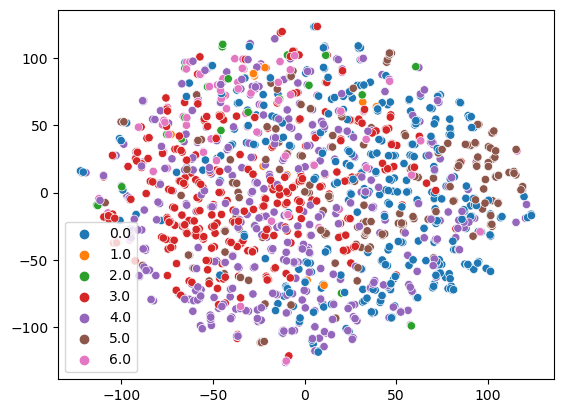

Epoch: 1 - Train Loss: 6.223855749766032


 50%|████████████████████████████                            | 1/2 [00:01<00:01,  1.14s/it]

In [ ]:
MODEL_NAME = 'sentence-transformers/all-MiniLM-L12-v2'
PATH_TO_SAVE = 'text_encoder_ready_L2_test2'
!mkdir -p {PATH_TO_SAVE}

supcon_model = TextCLIP(
    TextEncoder(MODEL_NAME, max_len=128),
    in_features_text=384,
    wide_proj=2048,
    proj_size=128,
    rate=0.2,
)

supcon_loss = SupConLoss(temperature=0.1, contrast_mode='all', base_temperature=0.1)
supcon_model.to(0)

#supcon_model = torch.compile(supcon_model)
scaler = torch.cuda.amp.GradScaler()

e = 0
old_f1 = -float('inf')
old_f1_meld = -float('inf')
old_f1_iemocap = -float('inf')

param_optimizer = list(supcon_model.named_parameters())

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.1
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5, betas=(0.9, 0.98), eps=1e-8)
scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.9, total_iters=10)

epochs = 9999

while e < epochs:
    supcon_model.train()
    epoch_loss = 0.0
    proj_val = []
    targets_val = []

    proj_train = []
    targets_train = []

    preds = []

    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        
        batch = train_text_final.iloc[batch_indices[0]]
        sentences = list(batch["text"])
        
        # Augment Context
        for k, s in enumerate(sentences):
            if '[CTX]' not in s:
                continue
                
            if np.random.rand() < 0.5:
                split = s.split('[CTX]')
                sentences[k] = split[1]
                    
        target = torch.Tensor(lab_encoder.transform(list(batch["label"])))

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            out, wide = supcon_model(sentences)
            out = out.unsqueeze(dim=1)
            loss = supcon_loss(out, labels=target)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(supcon_model.parameters(), 20.0)
        
        scaler.step(opt)
        scaler.update()
        
        opt.zero_grad(set_to_none=True)
        
        epoch_loss += loss.item()
        proj_train.append(np.array(wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del out
        del wide
        gc.collect()
        torch.cuda.empty_cache()
        
    scheduler.step()
    proj_train = np.concatenate(proj_train, axis=0)
    targets_train = np.concatenate(targets_train, axis=0)
    
    clf = FaissKNeighbors(k=128)
    clf.fit(proj_train, np.array(targets_train, dtype=int))

    epoch_loss = epoch_loss/len(train_loader)
    supcon_model.eval()
    
    for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
        with torch.no_grad():
        
            batch = test_df_erc.iloc[batch_indices[0]]
            sentences = list(batch["text"])
            target = torch.Tensor(lab_encoder.transform(list(batch["label"])))
            
            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                _, wide = supcon_model(sentences)
    
            wide = np.array(wide.cpu())
            pred = clf.predict(wide)

            preds.append(pred)
            proj_val.append(wide)
            targets_val.append(np.array(target.cpu()))

            del wide
            del target
            gc.collect()
            torch.cuda.empty_cache()

    proj_val = np.concatenate(proj_val, axis=0)
    targets_val = np.concatenate(targets_val, axis=0)
    preds = np.array(np.concatenate(preds, axis=0))

    general_f1 = f1_score(targets_val, preds, average='weighted')
    general_acc = accuracy_score(targets_val, preds)
    
    meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
    iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index
    
    general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
    general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])
    
    general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
    general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])
    
    print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
    print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
    print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')

    idx = np.random.randint(len(proj_val), size=2000)

    proj_val_samp = proj_val[idx, :]
    targets_val_samp = targets_val[idx]
    tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val_samp)

    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=targets_val_samp, palette='tab10')
    plt.show()

    print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
    e += 1

    with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
        f.write(f'General - KNN F1 (weighted): {general_f1} Acc: {general_acc}')
        f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        
    if general_f1 > old_f1 or general_f1_iemocap > old_f1_iemocap or general_f1_meld > old_f1_meld:
        checkpoint = {"model": supcon_model.state_dict(),
                  "optimizer": opt.state_dict(),
                  "scaler": scaler.state_dict()}
        torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')